<a href="https://colab.research.google.com/github/Lilchoto3/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [36]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [38]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [39]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [40]:
# MY CODE STARTS HERE

# Start by getting a validating portion of my training data
train, val = train_test_split(train, train_size=.8, test_size=.2, stratify=train['status_group'], random_state=42)

print(train.shape, val.shape, test.shape)

(47520, 41) (11880, 41) (14358, 40)


In [0]:
import numpy as np

# I also want to clean various parts of the data like in the lecture
def clean_dfs(X_to_clean):
  # Copy dataframe to prevent warnings
  X_to_clean = X_to_clean.copy()

  # Fix zero and near-zero positionals, replace with NaNs
  X_to_clean['latitude'] = X_to_clean['latitude'].replace(-2e-08,0)
  for col in ['longitude','latitude']:
    X_to_clean[col] = X_to_clean[col].replace(0, np.NaN)

  # Drop a duplicate column
  X_to_clean = X_to_clean.drop(['quantity_group'], axis=1)

  return X_to_clean

train = clean_dfs(train)
val = clean_dfs(val)
test = clean_dfs(test)

In [42]:
# Get an idea of an overall baseline concerning the water pumps
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [43]:
# So this means that, if we were to guess that all of them were functional,
# we'd be wrong 46% of the time, which isn't good; this baseline
# model of always guessing that they're fine is underfitted.

# First things first, however, I need to set up my various matrixes for train, val, and test
# I don't want to use stuff like high cardinal catagorical data for my features though,
# so lets get to work whittling that sort of stuff down

# First up, the target, which is the status of the pump
target = 'status_group'

# Now to pick my features; I don't want the target in my features, nor 'id', because it's useless data
features = train.drop([target, 'id'], axis=1)

# I'd like to keep all of the numerical features
num_features = features.select_dtypes(include='number').columns.tolist()

# I'd also like to keep all of the low-cardinal catagorical ones, too
cat_features = features.select_dtypes(exclude='number').nunique()
cat_features = cat_features[cat_features <= 50].index.tolist()

features = num_features + cat_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# Now to create my matrixes
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
# There is no y_test; that will be created by me and submitted to Kaggle.

In [45]:
# So, I have the baseline created using the mean,
# now I want to make the opposite: an overfitted model.

# I'm going to set up a decision tree classifier without any hyperparameters
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# I'm also going to do it all in a pipeline, because holy moly is that faster to write
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)

# Fit model with pipeline
pipeline.fit(X_train, y_train)

# How'd it do?
print(f'Train Accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation Accuracy: {pipeline.score(X_val, y_val)}')

Train Accuracy: 0.9954755892255892
Validation Accuracy: 0.7585858585858586


In [46]:
# Exactly what I exxpected: overfitting the training data
# but it fits the validation data better than the baseline, which is interesting.

# Now, however, I want to see if I can mellow out the decision tree so it's not
# overfitting as hard, but fitting the validation data better.

# I'm going to do this in a for loop to see which min_settings_leaf value
# gets me the best bang for my buck.
for i in range(1,20): # this is gonna take a while
  pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(strategy='mean'),
      StandardScaler(),
      DecisionTreeClassifier(random_state=42, min_samples_leaf=i)
  )

  # Fit model
  pipeline.fit(X_train, y_train)

  # Get results
  print(f'Min Samples Leaf: {i}')
  print(f'\tTrain Accuracy: {pipeline.score(X_train, y_train)}')
  print(f'\tValidation Accuracy: {pipeline.score(X_val, y_val)}\n')

Min Samples Leaf: 1
	Train Accuracy: 0.9954755892255892
	Validation Accuracy: 0.7585858585858586

Min Samples Leaf: 2
	Train Accuracy: 0.9343644781144781
	Validation Accuracy: 0.7618686868686869

Min Samples Leaf: 3
	Train Accuracy: 0.9103535353535354
	Validation Accuracy: 0.7654040404040404

Min Samples Leaf: 4
	Train Accuracy: 0.888510101010101
	Validation Accuracy: 0.7675084175084175

Min Samples Leaf: 5
	Train Accuracy: 0.876010101010101
	Validation Accuracy: 0.7724747474747474

Min Samples Leaf: 6
	Train Accuracy: 0.8648148148148148
	Validation Accuracy: 0.7755892255892256

Min Samples Leaf: 7
	Train Accuracy: 0.8558291245791246
	Validation Accuracy: 0.7728956228956229

Min Samples Leaf: 8
	Train Accuracy: 0.8488636363636364
	Validation Accuracy: 0.7718855218855218

Min Samples Leaf: 9
	Train Accuracy: 0.8429082491582491
	Validation Accuracy: 0.772979797979798

Min Samples Leaf: 10
	Train Accuracy: 0.8377314814814815
	Validation Accuracy: 0.7718855218855218

Min Samples Leaf: 11
	

In [64]:
# It looks like a min_samples_leaf of 6 is the best for this data set
# but regardless, all of the validation tests aren't that great to begin with,
# it doesn't seem like changing that value changes the validation accuracy,
# moreso only the training accuracy, which goes down as the validation is increased.

# I want to try, just as a test, to see what results I'd get with a
# Logistic regression.
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter('ignore')

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(multi_class='auto',solver='lbfgs',n_jobs=1)
)

# Fit model with pipeline
pipeline.fit(X_train, y_train)

# How'd it do?
print(f'Logistic Regression:')
print(f'\tTrain Accuracy: {pipeline.score(X_train, y_train)}')
print(f'\tValidation Accuracy: {pipeline.score(X_val, y_val)}')

Logistic Regression:
	Train Accuracy: 0.7335227272727273
	Validation Accuracy: 0.7308080808080808


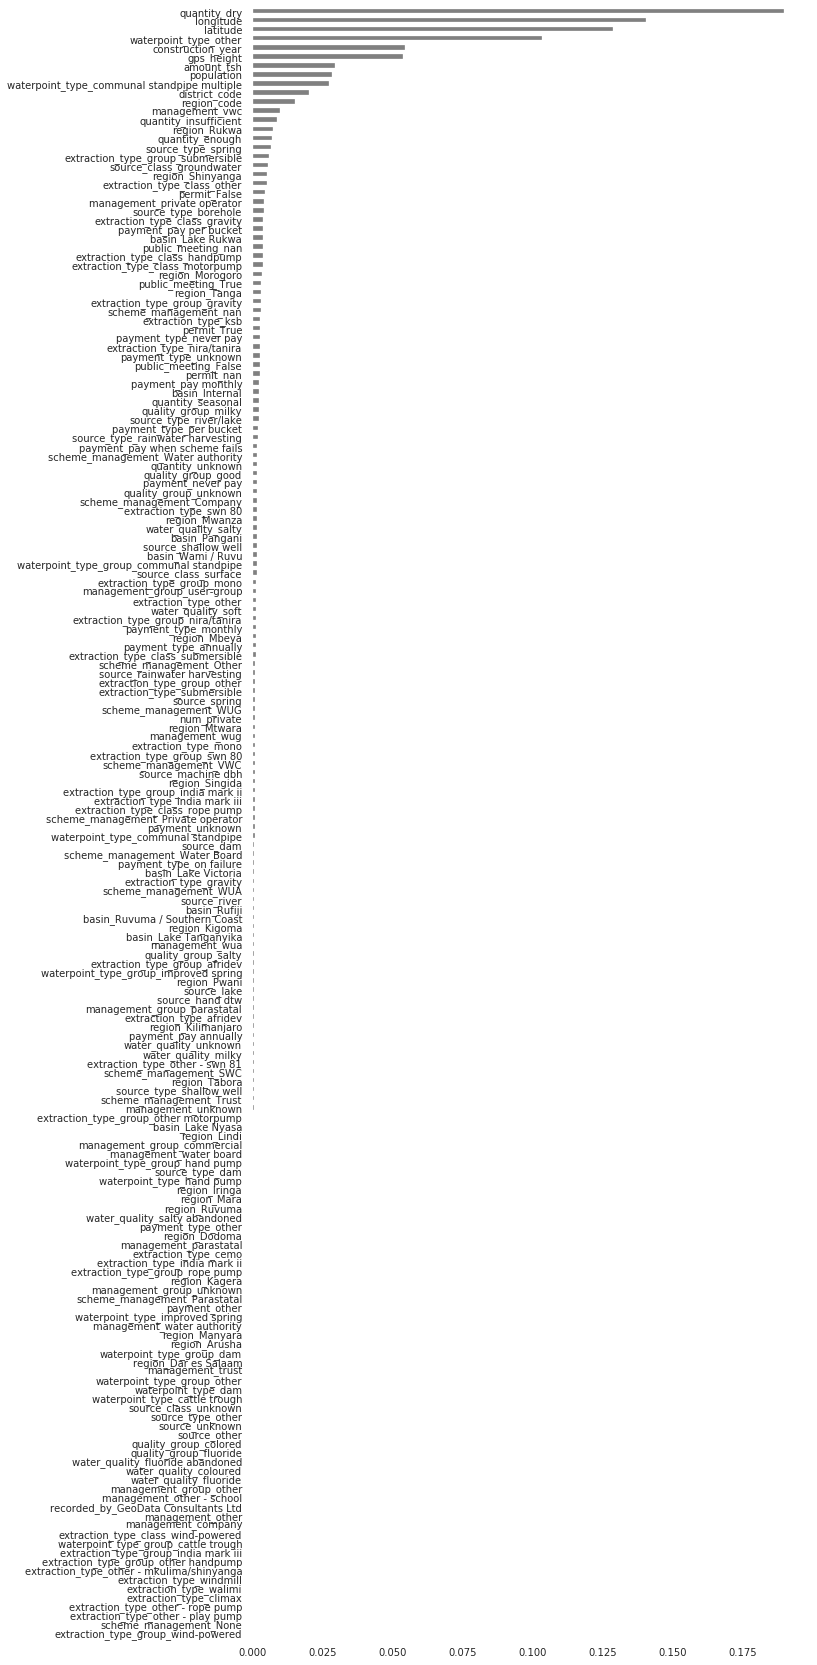

In [62]:
# Hm. No luck there.

# Alright, I'm gonna set up my pipeline to make the best version I got from my tests
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, min_samples_leaf=6)
)

# Fit model with pipeline
pipeline.fit(X_train, y_train)

# Plot coefficients
import matplotlib.pyplot as plt
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)

plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='gray')
plt.show()

In [66]:
# Prep a Kaggle submission
sample_submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [69]:
# Okay so lets start by getting a prediction from my model
y_pred = pipeline.predict(X_test)
y_pred

array(['non functional', 'functional', 'non functional', ...,
       'functional', 'functional', 'non functional'], dtype=object)

In [74]:
# Alright, now I should just be able to attach the 'id' column onto that array
kaggle_sub = pd.DataFrame(data=y_pred,index=test['id'],columns=['status_group']).reset_index()

kaggle_sub.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional


In [0]:
kaggle_sub.to_csv('Zachary_Luck_03_16_2020_Lambda_Kaggle_Challenge.csv')